## 1. Introduction

Processing data comes in many forms. Statistical analysis is only one stage of any data science workflow, and it assumes that you have cleaned, preprocessed and organized your data before hand. Usually the raw data we receive as an output of an experimental software, from other scientists or the web, is messy, has unnecessary information, missing values, lacks explicit information you need, etc. 

For many people, their first instinct is to open the data with Excell and to manually clean-up the data, by replacing values, creating new columns, etc, entirely by hand. The problem with that approach is that you cannot easily replicate the steps you have taken to transform the raw data into the final format you use for your analyses. This issue has many consequence, but among the two most common are, first, that if you get new or additional data from the same source, you would have to manually perform the same operations again, and second, if you make a mistake it would be difficult to identify where exactly that happened. The best approach is to preprocess your data with a script in the same way you do your analyses. However, doing so in base R can be quite cumbersome. In this tutorial, you will learn how to use tools for the **`tidyverse`** packages. Tidyverse is a collection of usefull packages, which include ggplot2, tidyr, dplyr, etc, combined in a single package.

Before we begin, install and load the `tidyverse` package:

In [1]:
# function to install the packages if missing, otherwise, just load them
import_packages <- function(packages) {
    for (package in packages) {
        if (!(package %in% row.names(installed.packages()))) {
            install.packages(package, repos = "http://cran.us.r-project.org")
        } 
        library(package, character.only = TRUE)
    }
}

import_packages(c('tidyverse'))

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 2.2.1     v purrr   0.2.4
v tibble  1.3.4     v dplyr   0.7.4
v tidyr   0.7.2     v stringr 1.2.0
v readr   1.1.1     v forcats 0.2.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Below is a summary of the functions we will review and their general description:

* **mutate()** - transforming existing variables and creating new variables
* **summarise()** - summarizing variables
* **filter()** - filtering dataframes
* **select()** - selecting columns to keep/remove
* **arrange()** - sorting by column/columns
* **join()** - merging multiple dataframes
* **group_by()** - performing the same operation to different subgroups of data and combining the results
* **spread()** - transforming data to wide format
* **gather()** - transforming data to long format
* **separate()** - split one column into multiple columns
* **unite()** - combine two columns into one

## 2. Tidy data

The key concept here is called **tidy data**. Tidy data assumes that your data is organized as follows:
* Columns are variables
* Rows are individual observations
* Observation for each variable is store in the corresponding cell

There are two versions of the tidy data format - long and wide. To illustrate the difference, imagine a repeated measures dataset, where you gather four observations for each subject at four different time points. In the **long data** format, the columns will be *subject*, *timepoint*, and *observation*, where each row will be one observation at a specific timepoint for a specific subject. For example:

In [2]:
long_data <- data.frame(subject = rep(1:3, each=4),
                        timepoint = rep(1:4, times=3),
                        observation = round(rnorm(12), 2))
long_data

subject,timepoint,observation
1,1,0.86
1,2,0.59
1,3,-0.56
1,4,0.36
2,1,0.39
2,2,0.92
2,3,-1.00
2,4,-0.81
3,1,-0.37
3,2,0.52


Alternatively, the data can be organized in a **wide format**, in which the four different timepoints are represented as different columns, each row is a single subject, and the observation for each timepoint is stored at a cell within that column. Like this (don't worry about the code for now, it is explained in the subsequent section):

In [3]:
long_data  %>% 
    mutate(timepoint = paste0('time',timepoint))  %>% 
    spread(timepoint, observation)

subject,time1,time2,time3,time4
1,0.86,0.59,-0.56,0.36
2,0.39,0.92,-1.00,-0.81
3,-0.37,0.52,0.30,1.19


## 3. Pipes - the %>% operator

You might have noticed the weird **%>%** operator in the code in the previous section. This operator is called a **'pipe'**. Pipes are present in many programming languages, but not in the base R, so you might not be familiar with them.

A pipe serves as a link between two objects, whether they be variables or functions. The pipe tells R to take the object on its left side and pass it as the first argument to the object on the right. 

Typically in R, if you want to pass an argument to a function, you specify it as `function(argument)`. For example, if you want to find the mean of the observations in the example shown above, in base R you would do this:

In [4]:
mean(long_data$observation)

[1] 0.1991667

If you use a pipe, you just put the argument on it's left side, and the function on the right, i.e., `variable  %>% function()`:

In [5]:
long_data$observation  %>% mean()

[1] 0.1991667

Now, you might be asking, what is the point of this? Pipes come in handy, when you have to perform multiple functions, where the input to each function is the output of the previous function. For example, let's say you not only want to find the mean of the observations, but also to round the value to 2 significant digits. In base R, you can do this in two ways:

1. nest the functions within one another
2. assign a temporary variable for the mean, and then round that value

In [6]:
# nested
round(mean(long_data$observation), 2)

# tmp variable
obs_mean = mean(long_data$observation)
round(obs_mean, 2)

[1] 0.2

[1] 0.2

Since pipes take the output of the expression on the left and send it as the first input to the expression on the right, you can do the following with pipes:

In [7]:
# with pipes
long_data$observation  %>% mean()  %>% round(2)

[1] 0.2

To increase readability even further, you can put a new row after each pipe operator - R automatically assumes that if there is nothing after the %>% on the same row, it should pass the result to whatever comes on the next row. Thus, we can rewrite the above example as:

In [8]:
# pipes on separate rows:
long_data$observation  %>% 
  mean() %>% 
  round(2)

[1] 0.2

Notice that typically the `round()` function takes as first argument the value to be rounded, and as a second argument the number of digits to which to round. When you use a pipe, the first argument is implicitely filled in with the value on the left, so the first argument you actually type corresponds to the number of significant digits to which to round. 

Pipes become very useful when using the functions we'll discuss below, because you would usually use many of them on the same data, and while the above example might be easy to read in all three cases, it becomes very difficult to track what is going on with the base R approach. **Thus pipes have two advantages:**

1. **Readability** - it is easier to see what goes on, because you can track the sequence naturally left to right. In contrast, with nested functions, you have to identify the inner-most function and then work yourway outwards.
2. **Efficiency** - do not clutter your environment with temporary variables that you needed for only one intermediary observation.

To show the difference in readability, here is how the code for the long to wide functions would look like, if we wrote it with nested functions, rather than with pipes:

In [9]:
# with pipes
long_data  %>% 
    mutate(timepoint = paste0('time',timepoint))  %>% 
    spread(timepoint, observation)

# nested functions
spread(mutate(long_data, timepoint = paste0('time',timepoint)), timepoint, observation)

# temporary variables
mutated_data <- mutate(long_data, timepoint = paste0('time',timepoint))
spread(mutated_data, timepoint, observation)

subject,time1,time2,time3,time4
1,0.86,0.59,-0.56,0.36
2,0.39,0.92,-1.00,-0.81
3,-0.37,0.52,0.30,1.19


subject,time1,time2,time3,time4
1,0.86,0.59,-0.56,0.36
2,0.39,0.92,-1.00,-0.81
3,-0.37,0.52,0.30,1.19


subject,time1,time2,time3,time4
1,0.86,0.59,-0.56,0.36
2,0.39,0.92,-1.00,-0.81
3,-0.37,0.52,0.30,1.19


## 4. Transforming data

We will use the `MathAchieve` dataset from the `nlme` package for illustrating the tidyverse functions. You can load/install the nlme package and save the MathAchieve data set to a `dat` variable like this:

In [10]:
import_packages('nlme')
dat <- MathAchieve


Attaching package: 'nlme'

The following object is masked from 'package:dplyr':

    collapse



The MathAcieve dataset contains mathematical achievement scores for 7185 individual students in a number of different schools. It contains information about the sex of each student, their socio-economic status, whether they are a member of a minority. You can view a detailed description of the dataset by typing:

In [11]:
?MathAchieve

Here's a peak at the data:

In [12]:
head(dat)

School,Minority,Sex,SES,MathAch,MEANSES
1224,No,Female,-1.528,5.876,-0.428
1224,No,Female,-0.588,19.708,-0.428
1224,No,Male,-0.528,20.349,-0.428
1224,No,Male,-0.668,8.781,-0.428
1224,No,Male,-0.158,17.898,-0.428
1224,No,Male,0.022,4.583,-0.428


### 4.1 Transforming existing variables and creating new variables -  **mutate()**

The `mutate()` command allows you to create new columns.  Let's say you want to center the MathAchievements scores by removing the mean:

In [13]:
dat <- mutate(dat, centered_math = MathAch - mean(MathAch))
head(dat)

School,Minority,Sex,SES,MathAch,MEANSES,centered_math
1224,No,Female,-1.528,5.876,-0.428,-6.871853
1224,No,Female,-0.588,19.708,-0.428,6.960147
1224,No,Male,-0.528,20.349,-0.428,7.601147
1224,No,Male,-0.668,8.781,-0.428,-3.966853
1224,No,Male,-0.158,17.898,-0.428,5.150147
1224,No,Male,0.022,4.583,-0.428,-8.164853


**In all dplyr commands, including mutate, the first argument is always the dataset**, and the subsequent arguments have the following form: `variable_name = value`. All commands in the `dplyr` package allow you to create and reference variables within a data.frame object, without have to type in the name of the data.frame each time. For example, if you want to create several variables in base R, you would have to do this everytime:

In [14]:
dat$centered_math = dat$MathAch - mean(dat$MathAch) # centers math achievement
dat$SES_zscores = (dat$SES - mean(dat$SES))/sd(dat$SES) # transforms SES into zscores

The second function above created a new variable in which we transform the MathAch scores by removing the overall mean. You have to reference the name of the dataset every time you refer to a variable. In contrast, when you use the mutate function you can simply type:

In [15]:
dat <- dat  %>%  
    mutate(centered_math = MathAch - mean(MathAch),  # center math achievement
           SES_zscores = (SES - mean(SES))/sd(SES),  # zscore the SES scores
           n_students = length(School))              # calculate the total number of students
head(dat)

School,Minority,Sex,SES,MathAch,MEANSES,centered_math,SES_zscores,n_students
1224,No,Female,-1.528,5.876,-0.428,-6.871853,-1.96077907,7185
1224,No,Female,-0.588,19.708,-0.428,6.960147,-0.75465379,7185
1224,No,Male,-0.528,20.349,-0.428,7.601147,-0.67766707,7185
1224,No,Male,-0.668,8.781,-0.428,-3.966853,-0.85730275,7185
1224,No,Male,-0.158,17.898,-0.428,5.150147,-0.20291563,7185
1224,No,Male,0.022,4.583,-0.428,-8.164853,0.02804452,7185


As you see, you can create multiple variables at the same time within a single mutate command, by separating them with commas. This time, rather than specifying *dat* as the first argument of mutate explicitely, we directed it with a pipe, as explained before. The first line should be read as *'Pass the dat variable to whatever follows, then save the results in the dat variable.*

### 4.2 Summarizing variables - summarise()

Mutate creates new variables within the existing dataset and does not change the number of rows. If you assign a summarizing function, as I did in the previous example with `n_students = length(School)`, which counts the number of observations in the `School` variable, it assign the result in each row of the dataset. If you want to create a new data.frame in which you store the summary values for one or more variables, you can use the summarise command. Let's get summaries for a few of the existing variables:

In [16]:
smry <- dat  %>% 
    summarise(n_students = length(School),
              minority_prop = mean(Minority == 'Yes'),
              female_prop = mean(Sex == 'Female'),
              SES_mean = mean(SES),
              SES_sd = sd(SES),
              SES_se = SES_sd / sqrt(n_students),
              math_mean = mean(MathAch),
              math_sd = sd(MathAch),
              math_se = math_sd / sqrt(n_students))
smry
              

n_students,minority_prop,female_prop,SES_mean,SES_sd,SES_se,math_mean,math_sd,math_se
7185,0.274739,0.5281837,0.0001433542,0.7793552,0.009194372,12.74785,6.878246,0.08114547


You should note several things. When you get to a new row, you can refer to a variable you have already created on a previous row. For example, when we calculate the standard error for the SES, we have put `SES_se = SES_sd / sqrt(n_students)`, in which SES_sd and n_students do not exist in the original data.frame, but are variables that we created on previous rows. We could have written it directly as `SES_se = sd(SES) / sqrt(length(School))`, but doing it in the above way is more efficient and readable.

### 4.3 Filtering a data.frame by removing rows based on a condition - filter()

Here's 3 scenarious":
* you identify that there is one bad school (e.g. 1224), which messed up during data collection and you want to remove it from the data.frame
* you find out that some students have a negative MathAchievement score, which is an error, and you want to remove them
* you want to separate the data for males and females in separate variables

You can do all of these things with the **`filter`** command:

In [17]:
cleaned_dat <- dat  %>% 
    filter(School != 1224,
           MathAch >= 0)

males <- filter(cleaned_dat, Sex == 'Male')
females <- filter(cleaned_dat, Sex == 'Female')

head(cleaned_dat); head(males); head(females)

School,Minority,Sex,SES,MathAch,MEANSES,centered_math,SES_zscores,n_students
1288,No,Female,-0.788,7.857,0.128,-4.8908526,-1.0112762,7185
1288,Yes,Male,-0.328,10.171,0.128,-2.5768526,-0.4210447,7185
1288,No,Male,0.472,15.699,0.128,2.9511474,0.6054449,7185
1288,No,Female,0.352,22.919,0.128,10.1711474,0.4514715,7185
1288,Yes,Female,-1.468,10.664,0.128,-2.0838526,-1.8837923,7185
1288,No,Female,0.202,13.543,0.128,0.7951474,0.2590047,7185


School,Minority,Sex,SES,MathAch,MEANSES,centered_math,SES_zscores,n_students
1288,Yes,Male,-0.328,10.171,0.128,-2.576853,-0.42104467,7185
1288,No,Male,0.472,15.699,0.128,2.951147,0.60544492,7185
1288,No,Male,-0.518,18.207,0.128,5.459147,-0.66483595,7185
1288,Yes,Male,-0.158,5.552,0.128,-7.195853,-0.20291563,7185
1288,No,Male,0.042,7.416,0.128,-5.331853,0.05370676,7185
1288,No,Male,0.682,18.792,0.128,6.044147,0.87489844,7185


School,Minority,Sex,SES,MathAch,MEANSES,centered_math,SES_zscores,n_students
1288,No,Female,-0.788,7.857,0.128,-4.8908526,-1.0112762,7185
1288,No,Female,0.352,22.919,0.128,10.1711474,0.4514715,7185
1288,Yes,Female,-1.468,10.664,0.128,-2.0838526,-1.8837923,7185
1288,No,Female,0.202,13.543,0.128,0.7951474,0.2590047,7185
1288,No,Female,0.152,3.534,0.128,-9.2138526,0.1948491,7185
1288,No,Female,-0.678,20.173,0.128,7.4251474,-0.8701339,7185


Here's where the pipe becomes useful. Let's say you want to calculate the summarise we described above separately for males and females. I will show you later how to do it more efficiently, but for the moment we can illustrate how you can chain commands with pipes. Rather than creating the intermediate **males** and **females** dataframes, we can chain the summarise function after the filter function. In the example below, we pass dat as the first argument of filter, then specify to keep only males, and then the resulting data.frame is passed on as the first argument to summarise:

In [18]:
# calculate summarise for males
dat  %>% 
 filter(Sex == 'Male')  %>% 
 summarise(SES_mean = mean(SES),
           SES_sd = sd(SES),
           math_mean = mean(MathAch),
           math_sd = sd(MathAch))

# calculate summarise for females
dat  %>% 
 filter(Sex == 'Female')  %>% 
 summarise(SES_mean = mean(SES),
           SES_sd = sd(SES),
           math_mean = mean(MathAch),
           math_sd = sd(MathAch))

SES_mean,SES_sd,math_mean,math_sd
0.05609145,0.7757862,13.6438,7.014392


SES_mean,SES_sd,math_mean,math_sd
-0.04983399,0.7792414,11.94752,6.653967


**_TIP_**: it is very easy to remove missing values by using the !is.na(variable) command. E.g. if some students are missing SES scores, you can exclude them by doing **`filter(dat, !is.na(SES))`**

### 4.4 Removing/selecting columns to keep - select()

Often the dataset contains many irrelevant columns, that make it difficult to display at once. You can easily choose which columns to keep or remove in a data.frame with the **`select()`** command. It has complex usage, and I suggest checking the help, i.e. type `?select`. The basic usage is:
* if you want to keep only specific variables, list them one after another like this:

In [19]:
select(dat, Sex, SES, MathAch)  %>% head()

Sex,SES,MathAch
Female,-1.528,5.876
Female,-0.588,19.708
Male,-0.528,20.349
Male,-0.668,8.781
Male,-0.158,17.898
Male,0.022,4.583


* If you want to remove only specific variables, list each with a - sign:

In [20]:
select(dat, -School, -SES_zscores)  %>% head()

Minority,Sex,SES,MathAch,MEANSES,centered_math,n_students
No,Female,-1.528,5.876,-0.428,-6.871853,7185
No,Female,-0.588,19.708,-0.428,6.960147,7185
No,Male,-0.528,20.349,-0.428,7.601147,7185
No,Male,-0.668,8.781,-0.428,-3.966853,7185
No,Male,-0.158,17.898,-0.428,5.150147,7185
No,Male,0.022,4.583,-0.428,-8.164853,7185


* If you want to keep a sequence of neighboring variables, you can specify the first and the last using a range:

In [21]:
select(dat, Sex:MEANSES)  %>% head()

Sex,SES,MathAch,MEANSES
Female,-1.528,5.876,-0.428
Female,-0.588,19.708,-0.428
Male,-0.528,20.349,-0.428
Male,-0.668,8.781,-0.428
Male,-0.158,17.898,-0.428
Male,0.022,4.583,-0.428


### 4.5 Sorting the data.frame by a column/s - arrange()

If you want to sort your data.frame by one or more columns you can use the arrange() command, where you list the variables in the order in which you want the sorting to occur. The default is to do ascending order for each variable. If you want descending order for one of them, you can surrond the variable in the desc(variable) command. Let's sort the school by descending number and then within each school, by aschending MathAch:

In [22]:
arrange(dat, desc(School), MathAch)  %>% head()

School,Minority,Sex,SES,MathAch,MEANSES,centered_math,SES_zscores,n_students
9586,No,Female,1.212,-2.832,0.627,-15.579853,1.5549478,7185
9586,No,Female,0.912,2.521,0.627,-10.226853,1.1700142,7185
9586,No,Female,0.602,4.021,0.627,-8.726853,0.7722495,7185
9586,No,Female,0.952,4.244,0.627,-8.503853,1.2213387,7185
9586,No,Female,0.762,5.112,0.627,-7.635853,0.9775474,7185
9586,No,Female,0.762,5.443,0.627,-7.304853,0.9775474,7185


### 4.6 combine/concatenate values from two columns into one - unite()

Right now minority and sex are two different variables. Let's say for some reason you want a new variable that specifies both, e.g. 'Female minority', 'Male minority', 'Female non-minority', 'Male non-minority'. This is often required when you are plotting and you want to use let's say 4 colors to denote each of the 4 categories, rather than using colors and size/shape, for example for two variables. You can combine variables with the unite() command. I'll first transform the minority command to say 'Minority' or 'Nonminority', not Yes or No, as it is now (if you are not familiar with the ifelse command, check the help):

In [23]:
dat <- dat  %>% 
    mutate(Minority = ifelse(Minority == 'Yes', 'Minority', 'Nonminority'))  %>% 
    unite(Combined_var, Sex, Minority, remove=FALSE)
head(dat)

School,Combined_var,Minority,Sex,SES,MathAch,MEANSES,centered_math,SES_zscores,n_students
1224,Female_Nonminority,Nonminority,Female,-1.528,5.876,-0.428,-6.871853,-1.96077907,7185
1224,Female_Nonminority,Nonminority,Female,-0.588,19.708,-0.428,6.960147,-0.75465379,7185
1224,Male_Nonminority,Nonminority,Male,-0.528,20.349,-0.428,7.601147,-0.67766707,7185
1224,Male_Nonminority,Nonminority,Male,-0.668,8.781,-0.428,-3.966853,-0.85730275,7185
1224,Male_Nonminority,Nonminority,Male,-0.158,17.898,-0.428,5.150147,-0.20291563,7185
1224,Male_Nonminority,Nonminority,Male,0.022,4.583,-0.428,-8.164853,0.02804452,7185


You can also specify the separator (by default it is '\_') and whether to remove the original variables. Check the help section.

### 4.7 split variable into multiple variables - separate()

The reverse of the operation above is called `separate()`. It becomes useful, for example, if you have the name of subjects stored in one variable, but you want to separate it into First and Last name. For the illustration, I will just reverse the above example (adding 1 to the new variables, to distinguish them from the existing Minority and Sex variables):

In [24]:
dat <- dat  %>% 
    separate(Combined_var, into=c('Sex1', 'Minority1'))
head(dat)

School,Sex1,Minority1,Minority,Sex,SES,MathAch,MEANSES,centered_math,SES_zscores,n_students
1224,Female,Nonminority,Nonminority,Female,-1.528,5.876,-0.428,-6.871853,-1.96077907,7185
1224,Female,Nonminority,Nonminority,Female,-0.588,19.708,-0.428,6.960147,-0.75465379,7185
1224,Male,Nonminority,Nonminority,Male,-0.528,20.349,-0.428,7.601147,-0.67766707,7185
1224,Male,Nonminority,Nonminority,Male,-0.668,8.781,-0.428,-3.966853,-0.85730275,7185
1224,Male,Nonminority,Nonminority,Male,-0.158,17.898,-0.428,5.150147,-0.20291563,7185
1224,Male,Nonminority,Nonminority,Male,0.022,4.583,-0.428,-8.164853,0.02804452,7185


## 5. Performing the same operation for multiple group and combining the results

In the filtering example, we saw how to subset the data.frame separately for males and females, and then to calculate the summaries. This is inefficient and also creates two separate data.frames. While you can join them manually afterwards, there is a much easier way with the **`group_by`** command.

When you pass a data.frame to a **group_by** command, you can specify names of variables, by which to split the data.frame. For example, if we specify the Minority and Sex variables in the group_by command, the data.frame will be **_implicitely_** split into 4 data.frames - one for each combination of minority status and sex. E.g.:

In [25]:
dat  %>% 
    group_by(Minority, Sex)  %>% 
    print()

# A tibble: 7,185 x 11
# Groups:   Minority, Sex [4]
   School   Sex1   Minority1    Minority    Sex    SES MathAch MEANSES
 *  <ord>  <chr>       <chr>       <chr> <fctr>  <dbl>   <dbl>   <dbl>
 1   1224 Female Nonminority Nonminority Female -1.528   5.876  -0.428
 2   1224 Female Nonminority Nonminority Female -0.588  19.708  -0.428
 3   1224   Male Nonminority Nonminority   Male -0.528  20.349  -0.428
 4   1224   Male Nonminority Nonminority   Male -0.668   8.781  -0.428
 5   1224   Male Nonminority Nonminority   Male -0.158  17.898  -0.428
 6   1224   Male Nonminority Nonminority   Male  0.022   4.583  -0.428
 7   1224 Female Nonminority Nonminority Female -0.618  -2.832  -0.428
 8   1224   Male Nonminority Nonminority   Male -0.998   0.523  -0.428
 9   1224 Female Nonminority Nonminority Female -0.888   1.527  -0.428
10   1224   Male Nonminority Nonminority   Male -0.458  21.521  -0.428
# ... with 7,175 more rows, and 3 more variables: centered_math <dbl>,
#   SES_zscores <dbl>, n

Now, the key is that the split is implicit - as you can see above, we still only have one data.frame, but now it has the specification:

`# Groups:   Minority, Sex [4]`

Every function that you add after group_by, will be evaluated separately for each group, and then the results will be combined. Let's say you want to calculate the mean and sd for SES and MathAch separately for the four groups:

In [26]:
dat  %>% 
    group_by(Minority, Sex)  %>% 
    summarise(ses_mean = mean(SES),
              ses_sd = sd(SES),
              math_mean = mean(MathAch),
              math_sd = sd(MathAch))

Minority,Sex,ses_mean,ses_sd,math_mean,math_sd
Minority,Male,-0.31357756,0.8123146,10.509925,6.788882
Minority,Female,-0.36915493,0.8351889,9.106734,6.265036
Nonminority,Male,0.19153245,0.7158262,14.791998,6.741109
Nonminority,Female,0.07473626,0.7189631,13.055744,6.470899


You easily get the resulting data.frame! If you have tried to do this in base R, you know how involved it is! What is going on behind the scenes is that the data.frame is separated into multiple data.frames, one for each combination of variables. Then the summarise function is executed on each, and the resulting 4 data.frames are automatically combined into a new resulting data.frame.

The group_by command works not only with `summarise`, but also with `transform`. While with summarise it creates a new data.frame with summary results, with transform it creates a new variable that is calculated separately for each group, and then combined into the final data.frame. This is useful, when, for example, we want to standardize variables within groups. Earlier we saw how to remove the overall mean of MathAch. Let's say, that we want to remove the mean of each school from only from the scores of that student. This is done for example when standardizing IQ scores across countries - the test is standardized to have a mean of 100 for the local population. So, for our example we can do:

In [27]:
dat  %>% 
 mutate(math_centered_overall = MathAch - mean(MathAch))  %>% 
 group_by(School)  %>% 
 mutate(math_centered_byschool = MathAch - mean(MathAch))  %>% 
 head()

School,Sex1,Minority1,Minority,Sex,SES,MathAch,MEANSES,centered_math,SES_zscores,n_students,math_centered_overall,math_centered_byschool
1224,Female,Nonminority,Nonminority,Female,-1.528,5.876,-0.428,-6.871853,-1.96077907,7185,-6.871853,-3.8394468
1224,Female,Nonminority,Nonminority,Female,-0.588,19.708,-0.428,6.960147,-0.75465379,7185,6.960147,9.9925532
1224,Male,Nonminority,Nonminority,Male,-0.528,20.349,-0.428,7.601147,-0.67766707,7185,7.601147,10.6335532
1224,Male,Nonminority,Nonminority,Male,-0.668,8.781,-0.428,-3.966853,-0.85730275,7185,-3.966853,-0.9344468
1224,Male,Nonminority,Nonminority,Male,-0.158,17.898,-0.428,5.150147,-0.20291563,7185,5.150147,8.1825532
1224,Male,Nonminority,Nonminority,Male,0.022,4.583,-0.428,-8.164853,0.02804452,7185,-8.164853,-5.1324468


The second line above gives us the math achievementd centered over the whole sample, while the 4th line, even though it looks the same, gives us the math achievement centered separately for each school. To illustrate, I will plot the means for each school under the two centerings (don't worry about the code, if you don't know ggplot2 yet):

No summary function supplied, defaulting to `mean_se()


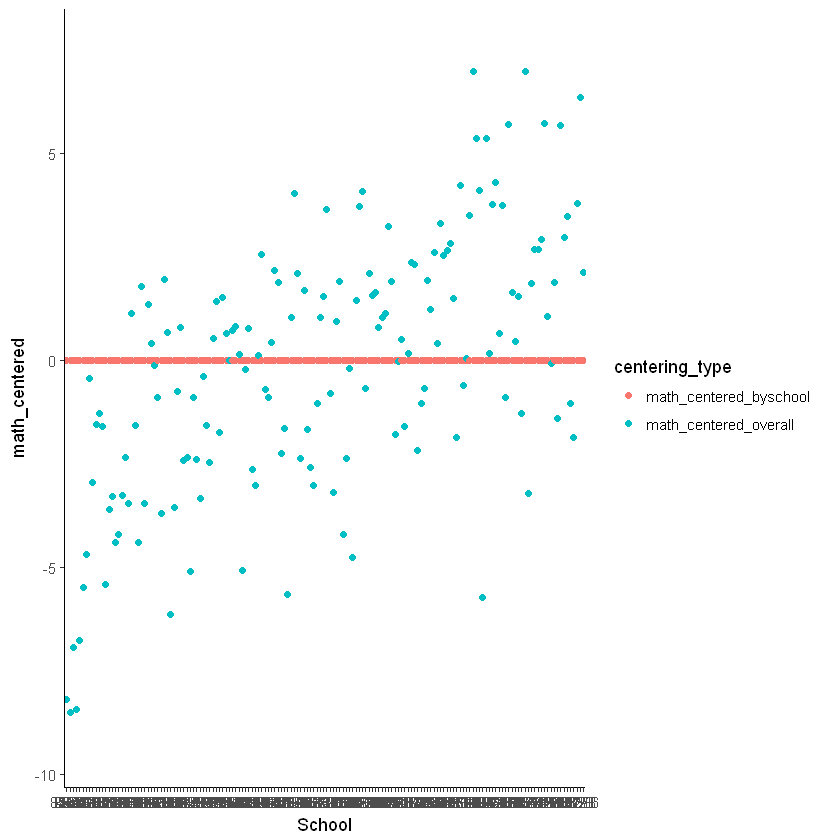

In [28]:
dat  %>% 
 mutate(math_centered_overall = MathAch - mean(MathAch))  %>% 
 group_by(School)  %>% 
 mutate(math_centered_byschool = MathAch - mean(MathAch))  %>% 
 gather(key = centering_type, value = math_centered, math_centered_overall, math_centered_byschool)  %>% 
 ggplot(aes(School, math_centered, color=centering_type)) +
    stat_summary(geom='point') +
    theme_classic()

You can even do fancy things like separate statistical analyses for each group, extract the fit statistic, and then combine the results together. But more on that in another tutorial

## 6. Restructuring data.frames - long to wide, wide to long, and merging data.frames.

Commands:
* spread() - transforming data to wide format
* gather() - transforming data to long format
* left_join() - merging multiple dataframes